# MBAN 6400 Group Project(Part A)

In [320]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from scipy.cluster.vq import whiten,vq,kmeans
import seaborn as sns

### Data Access

In [321]:
# read data
cc_data = pd.read_csv('credit_card.csv')
cc_data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.90,0.82,95.40,0.00,95.4,0.00,0.17,0.00,0.08,0.00,0.0,2.0,1000.0,201.80,139.51,0.00,12.0
1,C10002,3202.47,0.91,0.00,0.00,0.0,6442.95,0.00,0.00,0.00,0.25,4.0,0.0,7000.0,4103.03,1072.34,0.22,12.0
2,C10003,2495.15,1.00,773.17,773.17,0.0,0.00,1.00,1.00,0.00,0.00,0.0,12.0,7500.0,622.07,627.28,0.00,12.0
3,C10004,1666.67,0.64,1499.00,1499.00,0.0,205.79,0.08,0.08,0.00,0.08,1.0,1.0,7500.0,0.00,NaN,0.00,12.0
4,C10005,817.71,1.00,16.00,16.00,0.0,0.00,0.08,0.08,0.00,0.00,0.0,1.0,1200.0,678.33,244.79,0.00,12.0


In [322]:
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  PURCHA

### Feature Engineering

In [323]:
data = cc_data.copy()
data['ONEOFFPURCHASES_TOTAL']=data['PURCHASES']-data['INSTALLMENTS_PURCHASES']
data['CREDIT_USED'] = data['PURCHASES'] + data['CASH_ADVANCE']
data["PCT_PAID"] = data['PAYMENTS']//data['CREDIT_USED']
data['PAID_FULL'] = data['PAYMENTS'] >= data['CREDIT_USED']
data['OVER_LIMIT'] = data['CREDIT_USED']> (data['CREDIT_LIMIT']*6)

In [324]:
# if data["PCT_PAID"] = inf, then credit used is 0, then that user is not an active user
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [325]:
data=data.drop(columns='PRC_FULL_PAYMENT')

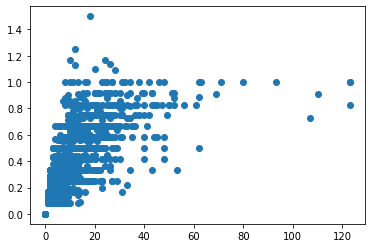

In [326]:
plt.scatter(data.CASH_ADVANCE_TRX,data.CASH_ADVANCE_FREQUENCY)

(array([ 204.,  190.,    0.,  196.,    0.,  175.,  236.,    0.,  365.,
        7584.]),
 array([ 6. ,  6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. ]),
 <BarContainer object of 10 artists>)

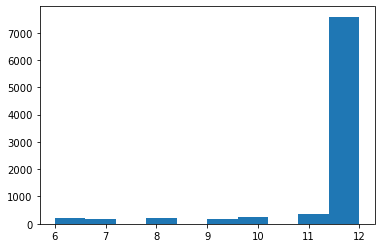

In [327]:
plt.hist(data.TENURE)

### Missing value imputation

In [328]:
# nulll value check
data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
TENURE                                0
ONEOFFPURCHASES_TOTAL                 0
CREDIT_USED                           0
PCT_PAID                              1
PAID_FULL                             0
OVER_LIMIT                            0
dtype: int64

In [329]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  PURCHA

In [330]:
# payments = 0 and MINIMUM_PAYMENTS = NaN, assign MINIMUM_PAYMENTS to 0, else assign to nan
# drop the row where CREDIT_LIMIT is missing
values = data[(data['PAYMENTS']==0)]['MINIMUM_PAYMENTS'].isna().map({False: np.nan, True: 0})
data['MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].fillna(values)
data1 = data.copy().dropna(subset=['CREDIT_LIMIT','PCT_PAID'])

In [331]:
# assign all other null value in MINIMUM_PAYMENTS as median value in the column
data1['MINIMUM_PAYMENTS'].fillna(data1['MINIMUM_PAYMENTS'].median(),inplace=True)

In [332]:
# Drop CUST_ID
X = data1.drop(columns = ['CUST_ID'])

In [333]:
# outlier percent function
# input: series
# return: percent of outlier data in the series
def outlier_percent(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((series < minimum) |(series > maximum))
    num_total = series.count()
    return (num_outliers/num_total)*100

In [334]:
X.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE',
       'ONEOFFPURCHASES_TOTAL', 'CREDIT_USED', 'PCT_PAID', 'PAID_FULL',
       'OVER_LIMIT'],
      dtype='object')

In [335]:
# retrun percentage of outlier in each column in the X dataframe
columns = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE',
       'ONEOFFPURCHASES_TOTAL', 'CREDIT_USED', 'PCT_PAID']
for column in columns:
    data2 = X[column]
    percent = str(round(outlier_percent(data2), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 7.77%
Outliers in "BALANCE_FREQUENCY": 16.67%
Outliers in "PURCHASES": 9.03%
Outliers in "ONEOFF_PURCHASES": 11.32%
Outliers in "INSTALLMENTS_PURCHASES": 9.69%
Outliers in "CASH_ADVANCE": 11.51%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 8.74%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 5.87%
Outliers in "CASH_ADVANCE_TRX": 8.99%
Outliers in "PURCHASES_TRX": 8.56%
Outliers in "CREDIT_LIMIT": 2.77%
Outliers in "PAYMENTS": 9.03%
Outliers in "MINIMUM_PAYMENTS": 10.07%
Outliers in "TENURE": 15.25%
Outliers in "ONEOFFPURCHASES_TOTAL": 11.35%
Outliers in "CREDIT_USED": 7.03%
Outliers in "PCT_PAID": 11.03%


In [336]:
# rescale each feature dimension of the observation set by its standard deviation
scaled_X = pd.DataFrame(whiten(X[columns]), columns = columns)
pt = PowerTransformer()
transformed_data = pd.DataFrame(pt.fit_transform(scaled_X), columns = columns)

In [337]:
transformed_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,ONEOFFPURCHASES_TOTAL,CREDIT_USED,PCT_PAID
count,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8.948000e+03,8948.000000,8.948000e+03,8.948000e+03,8.948000e+03
mean,1.524633e-16,4.637427e-16,6.352640e-18,-1.079949e-16,-8.734879e-17,-1.429344e-17,8.734879e-18,1.397581e-16,1.111712e-17,7.226128e-17,7.543759e-18,5.399744e-17,-2.922214e-16,-1.270528e-17,8.258431e-17,0.000000,-4.446848e-17,-4.129216e-17,-1.556397e-16
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056,1.000056e+00,1.000056e+00,1.000056e+00
min,-1.289725e+00,-2.069662e+00,-1.138069e+00,-8.278643e-01,-9.296663e-01,-8.048818e-01,-1.311925e+00,-9.278434e-01,-1.020970e+00,-9.035322e-01,-8.589690e-01,-1.204374e+00,-2.381417e+00,-1.670981e+00,-1.547432e+00,-2.525413,-7.960521e+00,-1.538500e+00,-8.425775e-01
25%,-1.025291e+00,-4.908690e-01,-1.005073e+00,-8.278643e-01,-9.296663e-01,-8.048818e-01,-1.018076e+00,-9.278434e-01,-1.020970e+00,-9.035322e-01,-8.589690e-01,-9.863591e-01,-9.400207e-01,-8.285891e-01,-7.699983e-01,0.422175,-8.175581e-01,-8.972849e-01,-8.425775e-01
50%,9.338270e-03,6.194185e-01,-1.725459e-01,-6.223792e-01,-3.429260e-01,-8.048818e-01,1.685499e-01,-1.523539e-02,-1.842187e-01,-9.035322e-01,-8.589690e-01,-4.617080e-02,-1.745577e-01,-1.213678e-01,-3.016167e-01,0.422175,-6.179557e-01,-6.902931e-02,-8.425775e-01
75%,8.149716e-01,6.194185e-01,8.357108e-01,9.339211e-01,9.051832e-01,1.018096e+00,1.045069e+00,1.005187e+00,1.066503e+00,1.035625e+00,1.008046e+00,7.759604e-01,8.761137e-01,7.662198e-01,7.886938e-01,0.422175,9.168672e-01,8.292039e-01,4.925974e-01
max,2.140452e+00,6.194185e-01,2.046136e+00,1.936808e+00,1.958863e+00,1.864350e+00,1.191505e+00,1.669039e+00,1.339931e+00,1.881207e+00,1.899278e+00,2.146829e+00,2.471001e+00,2.166535e+00,2.095259e+00,0.422175,1.950674e+00,2.235378e+00,2.300403e+00


In [338]:
for column in transformed_data.columns:
    data3 = transformed_data[column]
    percent = str(round(outlier_percent(data3), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 0.0%
Outliers in "BALANCE_FREQUENCY": 0.0%
Outliers in "PURCHASES": 0.0%
Outliers in "ONEOFF_PURCHASES": 0.0%
Outliers in "INSTALLMENTS_PURCHASES": 0.0%
Outliers in "CASH_ADVANCE": 0.0%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 0.0%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_TRX": 0.0%
Outliers in "PURCHASES_TRX": 0.0%
Outliers in "CREDIT_LIMIT": 0.0%
Outliers in "PAYMENTS": 0.0%
Outliers in "MINIMUM_PAYMENTS": 0.0%
Outliers in "TENURE": 15.25%
Outliers in "ONEOFFPURCHASES_TOTAL": 0.02%
Outliers in "CREDIT_USED": 0.0%
Outliers in "PCT_PAID": 0.0%


/var/folders/9s/zz7k8h2949d__gv0rmbn3yj80000gn/T/ipykernel_46535/2424518096.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(transformed_data.corr(), dtype=np.bool))


Text(0.5, 1.0, 'Correlation Heatmap')

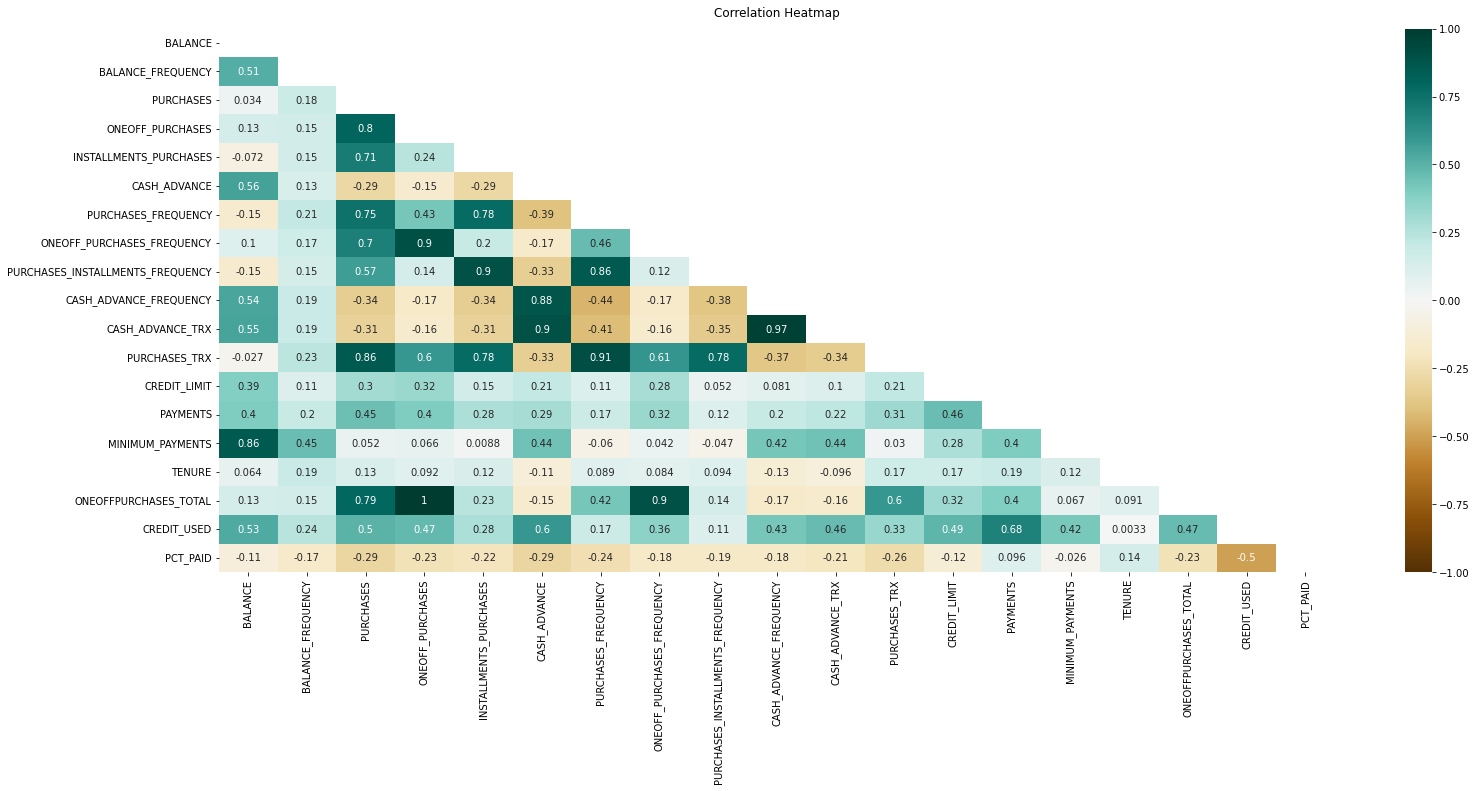

In [339]:
plt.figure(figsize=(25, 10))
mask = np.triu(np.ones_like(transformed_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(transformed_data.copy().corr(), mask=mask, vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [340]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [341]:
calculate_pvalues(transformed_data)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,ONEOFFPURCHASES_TOTAL,CREDIT_USED,PCT_PAID
BALANCE,0.0,0.0,0.0011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0094,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BALANCE_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PURCHASES,0.0011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ONEOFF_PURCHASES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
INSTALLMENTS_PURCHASES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4065,0.0,0.0,0.0,0.0
CASH_ADVANCE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PURCHASES_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ONEOFF_PURCHASES_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.0,0.0,0.0,0.0
PURCHASES_INSTALLMENTS_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CASH_ADVANCE_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [342]:
p_value = calculate_pvalues(transformed_data)
insignificant=[]
for column in p_value.columns:
    for i in p_value.index:
        if p_value[column][i]>0.05:
            insignificant.append([column,i])



In [343]:
insignificant

[['INSTALLMENTS_PURCHASES', 'MINIMUM_PAYMENTS'],
 ['MINIMUM_PAYMENTS', 'INSTALLMENTS_PURCHASES'],
 ['TENURE', 'CREDIT_USED'],
 ['CREDIT_USED', 'TENURE']]

In [345]:
new_data = pd.concat([X,data[['PAID_FULL','OVER_LIMIT']]],axis=1)

In [348]:
new_data = new_data.dropna()

In [350]:
new_data.to_csv('new_data.csv')

## Clustering

### K-means Clustering

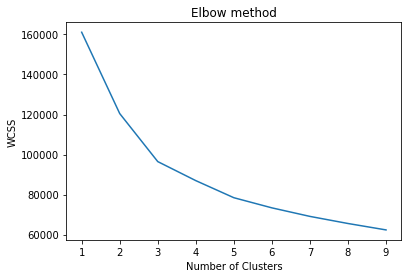

In [92]:
# KMeans Model
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(transformed_data) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [98]:
# Three Clusters
centroids,_ = kmeans(transformed_data, 3)
transformed_data['cluster_labels'], _ = vq(transformed_data, centroids)
cross_tab_3 = pd.crosstab(transformed_data['cluster_labels'],transformed_data['cluster_labels'])
print(cross_tab_3)

cluster_labels     0     1     2
cluster_labels                  
0               2619     0     0
1                  0  3301     0
2                  0     0  3029


In [99]:
# Four clusters
centroids,_ = kmeans(transformed_data, 4)
transformed_data['cluster_labels'], _ = vq(transformed_data, centroids)
cross_tab_4 = pd.crosstab(transformed_data['cluster_labels'],transformed_data['cluster_labels'])
print(cross_tab_4)

cluster_labels     0     1     2     3
cluster_labels                        
0               2040     0     0     0
1                  0  2810     0     0
2                  0     0  1597     0
3                  0     0     0  2502


In [100]:
centroids,_ = kmeans(transformed_data, 5)
transformed_data['cluster_labels'], _ = vq(transformed_data, centroids)
cross_tab_5 = pd.crosstab(transformed_data['cluster_labels'],transformed_data['cluster_labels'])
print(cross_tab_5)

cluster_labels     0     1     2     3     4
cluster_labels                              
0               1019     0     0     0     0
1                  0  2531     0     0     0
2                  0     0  2051     0     0
3                  0     0     0  1757     0
4                  0     0     0     0  1591
